In [ ]:
%load_ext autoreload
%autoreload 2

In [192]:
from examples.SMO.turbo import train_turbo, get_initial_points, TurboState
from uncertaintylearning.utils.networks import create_optimizer, create_network
import torch
import os
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
features = 'xv'
dim = 10
batch_size = 1
n_init = 20
use_log_unc = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
SMOKE_TEST = os.environ.get("SMOKE_TEST")
low, up = -10, 15
fun = Ackley(dim=10, negate=True).to(dtype=dtype, device=device)
fun.bounds[0, :].fill_(low)
fun.bounds[1, :].fill_(up)
dim = fun.dim
lb, ub = fun.bounds

X_test = get_initial_points(dim, 1000)


def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))

In [ ]:
n_seeds = 3
turbo_results = np.zeros((n_seeds, 250))
turbo_deup_results = np.zeros((n_seeds, 250))
for seed in range(n_seeds):
    X_turbo = get_initial_points(dim, n_init)
    Y_turbo = torch.tensor(
        [eval_objective(x) for x in X_turbo], dtype=dtype, device=device
    ).unsqueeze(-1)
    
    state = TurboState(dim, batch_size=batch_size, max_step=120)
    best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=False, batch_size=1)
    turbo_results[seed, :len(best_values)] = best_values
    
    state = TurboState(dim, batch_size=batch_size, max_step=120)
    best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=True, use_log_unc=True, 
                                                          batch_size=1, features='v')
    turbo_deup_results[seed, :len(best_values)] = best_values

In [ ]:
def truncate(arr):
    idxs = [i for i in range(len(arr)) if arr[i] == 0]
    if len(idxs) == 0:
        return idxs
    return arr[:idxs[0]]

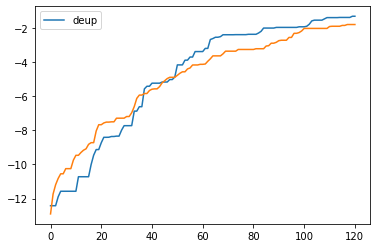

In [194]:
plt.plot(truncate(np.mean(turbo_deup_results, axis=0)), label='deup')
plt.plot(truncate(np.mean(turbo_results, axis=0)))
plt.legend()

In [195]:
n_seeds = 3
turbo_results = np.zeros((n_seeds, 250))
turbo_deup_results = np.zeros((n_seeds, 250))
for seed in range(n_seeds):
    X_turbo = get_initial_points(dim, n_init)
    Y_turbo = torch.tensor(
        [eval_objective(x) for x in X_turbo], dtype=dtype, device=device
    ).unsqueeze(-1)
    
    state = TurboState(dim, batch_size=batch_size, max_step=150)
    best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=False, batch_size=1)
    turbo_results[seed, :len(best_values)] = best_values
    
    state = TurboState(dim, batch_size=batch_size, max_step=150)
    best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=True, use_log_unc=True, 
                                                          batch_size=1, features='v')
    turbo_deup_results[seed, :len(best_values)] = best_values

21) Best value: -1.19e+01, TR length: 8.00e-01
22) Best value: -1.17e+01, TR length: 8.00e-01
23) Best value: -1.13e+01, TR length: 8.00e-01
24) Best value: -1.13e+01, TR length: 8.00e-01
25) Best value: -1.06e+01, TR length: 8.00e-01
26) Best value: -1.00e+01, TR length: 8.00e-01
27) Best value: -9.83e+00, TR length: 8.00e-01
28) Best value: -9.83e+00, TR length: 8.00e-01
29) Best value: -9.83e+00, TR length: 8.00e-01
30) Best value: -9.83e+00, TR length: 8.00e-01
31) Best value: -9.37e+00, TR length: 8.00e-01
32) Best value: -8.72e+00, TR length: 8.00e-01
33) Best value: -8.37e+00, TR length: 8.00e-01
34) Best value: -8.37e+00, TR length: 8.00e-01
35) Best value: -8.31e+00, TR length: 8.00e-01
36) Best value: -8.12e+00, TR length: 8.00e-01
37) Best value: -8.12e+00, TR length: 8.00e-01
38) Best value: -8.11e+00, TR length: 8.00e-01
39) Best value: -8.11e+00, TR length: 8.00e-01
40) Best value: -8.11e+00, TR length: 8.00e-01
41) Best value: -7.91e+00, TR length: 8.00e-01
42) Best valu

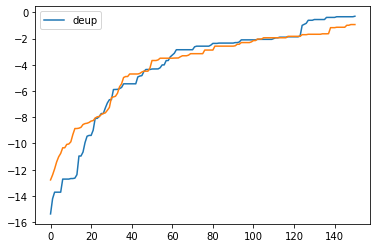

In [196]:
plt.plot(truncate(np.mean(turbo_deup_results, axis=0)), label='deup')
plt.plot(truncate(np.mean(turbo_results, axis=0)))
plt.legend()

Text(0.5, 1.0, 'Optimizing Ackley 10 fct with Turbo - 3 seeds')

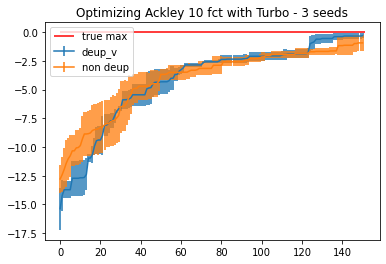

In [211]:
plt.errorbar(range(len(truncate(np.mean(turbo_deup_results, axis=0)))),
             truncate(np.mean(turbo_deup_results, axis=0)),
             truncate(np.std(turbo_deup_results, axis=0)), label='deup_v')

plt.errorbar(range(len(truncate(np.mean(turbo_results, axis=0)))),
             truncate(np.mean(turbo_results, axis=0)),
             truncate(np.std(turbo_results, axis=0)), label='non deup')
plt.hlines(0, 0, len(truncate(np.mean(turbo_results, axis=0))), color='red', label='true max')
plt.legend()
plt.title('Optimizing Ackley 10 fct with Turbo - 3 seeds')